# 1. Base code for calculating the function

In [ ]:
import math
import numpy as np

def simulated_annealing_minimize_trace(
    f,
    bounds=((-3.0, 3.0), (-2.0, 2.0)),
    x0=None,
    T0=5.0,
    alpha=0.95,
    steps_per_T=800,
    Tmin=1e-3,
    max_evals=100_000,
    step0=(0.6, 0.4),
    seed=0,
):
    rng = np.random.default_rng(seed)
    (xmin, xmax), (ymin, ymax) = bounds

    # Initial solution
    if x0 is None:
        x = rng.uniform(xmin, xmax)
        y = rng.uniform(ymin, ymax)
    else:
        x = float(np.clip(x0[0], xmin, xmax))
        y = float(np.clip(x0[1], ymin, ymax))

    fx = f(x, y)
    best_x, best_y, best_fx = x, y, fx

    T = float(T0)
    evals = 1
    sx0, sy0 = step0

    # Trace containers
    trace = {
        "eval": [],
        "T": [],
        "current_z": [],
        "best_z": [],
        "accepted": [],   # 1 accepted move, 0 rejected
    }

    while T > Tmin and evals < max_evals:
        scale = math.sqrt(T / T0)
        sx = sx0 * scale
        sy = sy0 * scale

        for _ in range(steps_per_T):
            if evals >= max_evals:
                break

            xn = np.clip(x + sx * rng.normal(), xmin, xmax)
            yn = np.clip(y + sy * rng.normal(), ymin, ymax)

            fn = f(xn, yn)
            evals += 1

            delta = fn - fx  # minimization

            accepted = 0
            if delta <= 0:
                x, y, fx = xn, yn, fn
                accepted = 1
            else:
                if rng.random() < math.exp(-delta / T):
                    x, y, fx = xn, yn, fn
                    accepted = 1

            if fx < best_fx:
                best_x, best_y, best_fx = x, y, fx

            # record trace
            trace["eval"].append(evals)
            trace["T"].append(T)
            trace["current_z"].append(fx)
            trace["best_z"].append(best_fx)
            trace["accepted"].append(accepted)

        T *= alpha

    return {
        "best_x": best_x,
        "best_y": best_y,
        "best_f": best_fx,
        "evals": evals,
        "final_T": T,
        "T0": T0,
        "alpha": alpha,
        "steps_per_T": steps_per_T,
        "Tmin": Tmin,
        "max_evals": max_evals,
        "step0": step0,
        "seed": seed,
        "x0": x0,
        "trace": trace
    }

In [ ]:
# creating  three folders for each step to save the CSV and PNG files in them
import os

# Define folder names for each step
FOLDERS = [
    "step1_baseline_results",
    "step2_annealing_schedules_results",
    "step3_stopping_criteria_results",
    "step4_combined_results"
]

# Create folders if they don't exist
for folder in FOLDERS:
    os.makedirs(folder, exist_ok=True)
    print(f"Folder '{folder}' created or already exists.")

Folder 'step1_baseline_results' created or already exists.
Folder 'step2_annealing_schedules_results' created or already exists.
Folder 'step3_stopping_criteria_results' created or already exists.
Folder 'step4_combined_results' created or already exists.


# 2. Step 1 — Run ONE baseline experiment

In [ ]:
import pandas as pd

def six_hump_camelback(x, y):
    return (4 - 2.1*x**2 + x**4/3)*x**2 + x*y + (-4 + 4*y**2)*y**2

# Baseline run
baseline_res = simulated_annealing_minimize_trace(
    six_hump_camelback,
    x0=(0.0, 0.0),
    T0=5.0,
    alpha=0.95,
    steps_per_T=800,
    Tmin=1e-3,
    max_evals=100_000,
    step0=(0.6, 0.4),
    seed=42
)

print("Baseline best:")
print("  x =", baseline_res["best_x"])
print("  y =", baseline_res["best_y"])
print("  z =", baseline_res["best_f"])
print("  evals =", baseline_res["evals"])
print("  final_T =", baseline_res["final_T"])

# Save summary (1 row)
x0 = baseline_res["x0"]
summary_df = pd.DataFrame([{
    "best_x": baseline_res["best_x"],
    "best_y": baseline_res["best_y"],
    "best_z": baseline_res["best_f"],
    "evals": baseline_res["evals"],
    "T0": baseline_res["T0"],
    "alpha": baseline_res["alpha"],
    "steps_per_T": baseline_res["steps_per_T"],
    "Tmin": baseline_res["Tmin"],
    "max_evals": baseline_res["max_evals"],
    "seed": baseline_res["seed"],
    "x0": x0[0] if x0 is not None else None,
    "y0": x0[1] if x0 is not None else None,
}])

summary_df.to_csv("step1_baseline_results/baseline_summary.csv", index=False)

# Save trace (many rows)
trace_df = pd.DataFrame(baseline_res["trace"])
trace_df.to_csv("step1_baseline_results/baseline_trace.csv", index=False)

print("Saved: baseline_summary.csv")
print("Saved: baseline_trace.csv")


Baseline best:
  x = -0.08903223708175749
  y = 0.7128364928628276
  z = -1.0316254851291824
  evals = 100000
  final_T = 0.008211465365418953
Saved: baseline_summary.csv
Saved: baseline_trace.csv


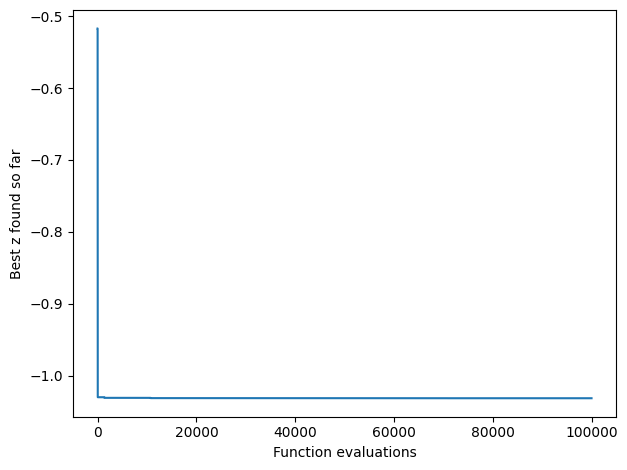

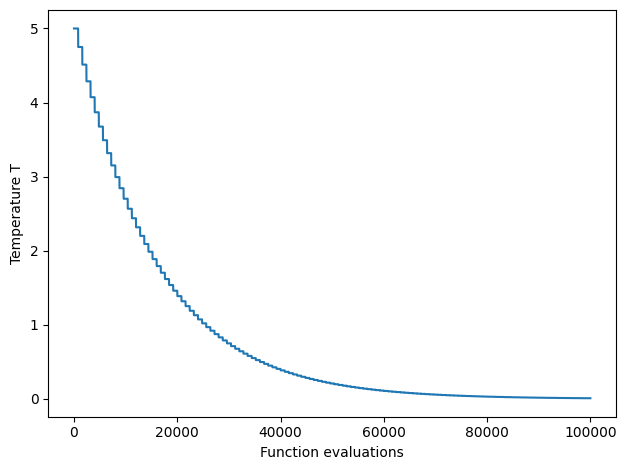

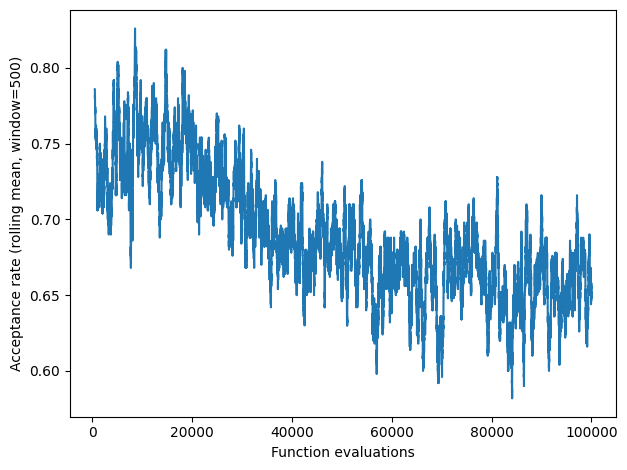

Saved plots:
  plot_best_z_vs_evals.png
  plot_temperature_vs_evals.png
  plot_acceptance_rate.png


In [ ]:
import matplotlib.pyplot as plt

# 1) Best z vs evaluations
plt.figure()
plt.plot(trace_df["eval"], trace_df["best_z"])
plt.xlabel("Function evaluations")
plt.ylabel("Best z found so far")
#plt.title("SA Baseline: Best z vs Evaluations")
plt.tight_layout()
plt.savefig("step1_baseline_results/plot_best_z_vs_evals.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations
plt.figure()
plt.plot(trace_df["eval"], trace_df["T"])
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
#plt.title("SA Baseline: Temperature vs Evaluations")
plt.tight_layout()
plt.savefig("step1_baseline_results/plot_temperature_vs_evals.png", dpi=300)
plt.show()

# 3) Acceptance rate (rolling window)
window = 500  # you can change this
acc_rate = trace_df["accepted"].rolling(window).mean()

plt.figure()
plt.plot(trace_df["eval"], acc_rate)
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
#plt.title("SA Baseline: Acceptance Rate")
plt.tight_layout()
plt.savefig("step1_baseline_results/plot_acceptance_rate.png", dpi=300)
plt.show()

print("Saved plots:")
print("  plot_best_z_vs_evals.png")
print("  plot_temperature_vs_evals.png")
print("  plot_acceptance_rate.png")


# 3. Step 2 — Define 3 annealing schedules

In [ ]:
# Defining three different annealing schedules:

schedules = [
    ("Case1: alpha_0.90", 0.90),
    ("Case2: alpha_0.95", 0.95),
    ("Case3: alpha_0.98", 0.98)]

In [ ]:
import pandas as pd

# Keep these FIXED for a fair schedule comparison
COMMON = dict(
    f=six_hump_camelback,
    x0=(0.0, 0.0),
    T0=5.0,
    steps_per_T=800,
    Tmin=1e-3,
    max_evals=100_000,
    step0=(0.6, 0.4),
    seed=42
)

step2_summaries = []
step2_traces = {}  # name -> DataFrame

for name, alpha in schedules:
    res = simulated_annealing_minimize_trace(alpha=alpha, **COMMON)

    # summary row
    step2_summaries.append({
        "schedule_name": name,
        "alpha": alpha,
        "best_x": res["best_x"],
        "best_y": res["best_y"],
        "best_z": res["best_f"],
        "evals": res["evals"],
        "final_T": res["final_T"],
        "T0": res["T0"],
        "steps_per_T": res["steps_per_T"],
        "Tmin": res["Tmin"],
        "max_evals": res["max_evals"],
        "seed": res["seed"],
        "x0": res["x0"],
    })

    # trace df
    trace_df = pd.DataFrame(res["trace"])
    step2_traces[name] = trace_df
    trace_df.to_csv(f"step2_trace_{name}.csv", index=False)

# Save combined summary
step2_summary_df = pd.DataFrame(step2_summaries)
step2_summary_df.to_csv("step2_annealing_schedules_results/step2_schedules_summary.csv", index=False)

step2_summary_df


,schedule_name,alpha,best_x,best_y,best_z,evals,final_T,T0,steps_per_T,Tmin,max_evals,seed,x0
0,Case1: alpha_0.90,0.90,-0.089703,0.712658,-1.031628,64801,0.000983,5.0,800,0.001,100000,42,"(0.0, 0.0)"
1,Case2: alpha_0.95,0.95,-0.089032,0.712836,-1.031625,100000,0.008211,5.0,800,0.001,100000,42,"(0.0, 0.0)"
2,Case3: alpha_0.98,0.98,0.089923,-0.713342,-1.031625,100000,0.400156,5.0,800,0.001,100000,42,"(0.0, 0.0)"


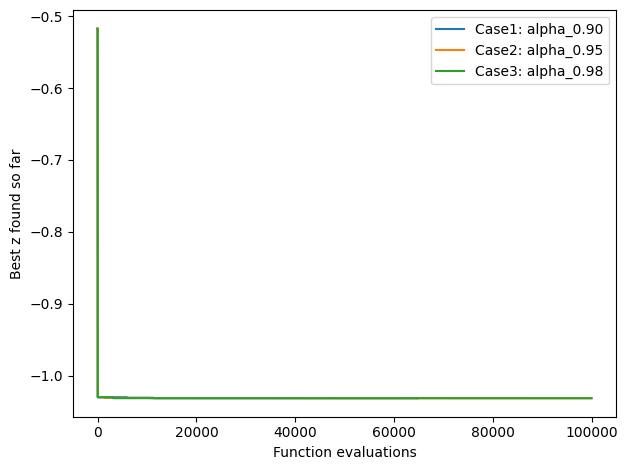

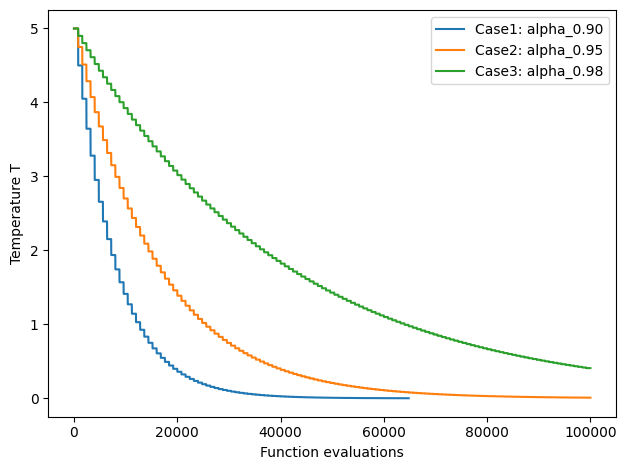

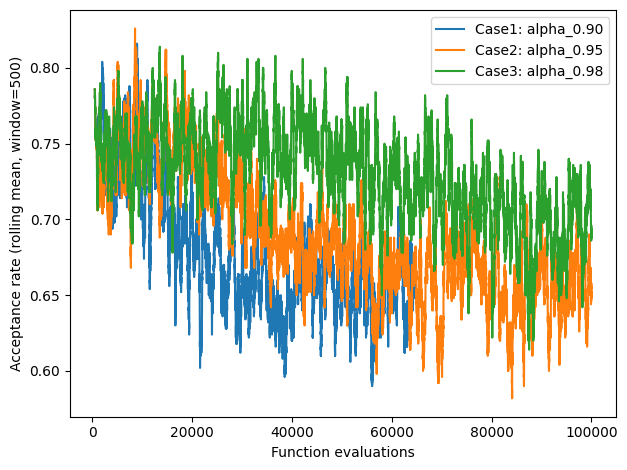

Saved PNG plots:
  step2_best_z_comparison.png
  step2_temperature_comparison.png
  step2_acceptance_rate_comparison.png

Saved CSV files:
  step2_schedules_summary.csv
  step2_trace_Case1: alpha_0.90.csv
  step2_trace_Case2: alpha_0.95.csv
  step2_trace_Case3: alpha_0.98.csv


In [ ]:
import matplotlib.pyplot as plt

# 1) Best z vs evaluations (all schedules on one plot)
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    plt.plot(df["eval"], df["best_z"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Best z found so far")
#plt.title("Best z vs Evaluations (Different Cooling Schedules)", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step2_annealing_schedules_results/step2_best_z_comparison.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations (all schedules)
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    plt.plot(df["eval"], df["T"], label=name)
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
#plt.title("Temperature vs Evaluations (Different Cooling Schedules)", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step2_annealing_schedules_results/step2_temperature_comparison.png", dpi=300)
plt.show()

# 3) Acceptance rate comparison (rolling mean)
window = 500
plt.figure()
for name, _ in schedules:
    df = step2_traces[name]
    acc_rate = df["accepted"].rolling(window).mean()
    plt.plot(df["eval"], acc_rate, label=name)
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
#plt.title("Acceptance Rate vs Evaluations", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step2_annealing_schedules_results/step2_acceptance_rate_comparison.png", dpi=300)
plt.show()

print("Saved PNG plots:")
print("  step2_best_z_comparison.png")
print("  step2_temperature_comparison.png")
print("  step2_acceptance_rate_comparison.png")
print("\nSaved CSV files:")
print("  step2_schedules_summary.csv")
for name, _ in schedules:
    print(f"  step2_trace_{name}.csv")



# 4. Step 3 — Define 3 stopping criteria

In [ ]:
stopping_rules = [
    ("Case1: Stop_Tmin_1e-3", dict(Tmin=1e-3, max_evals=100_000)),  # baseline
    ("Case2: Stop_budget_30k", dict(Tmin=0.0,  max_evals=30_000)),  # budget-limited
    ("Case3: Stop_Tmin_1e-6", dict(Tmin=1e-6, max_evals=100_000)),  # stricter Tmin
]

In [ ]:
import pandas as pd

# Keep these FIXED for a fair stopping-rule comparison
COMMON_STOP = dict(
    f=six_hump_camelback,
    x0=(0.0, 0.0),
    T0=5.0,
    alpha=0.95,           # fixed schedule here
    steps_per_T=800,
    step0=(0.6, 0.4),
    seed=42
)

step3_summaries = []
step3_traces = {}

for name, stop_kwargs in stopping_rules:
    res = simulated_annealing_minimize_trace(**COMMON_STOP, **stop_kwargs)

    step3_summaries.append({
        "stop_name": name,
        "Tmin": stop_kwargs["Tmin"],
        "max_evals": stop_kwargs["max_evals"],
        "best_x": res["best_x"],
        "best_y": res["best_y"],
        "best_z": res["best_f"],
        "evals": res["evals"],
        "final_T": res["final_T"],
        "T0": res["T0"],
        "alpha": res["alpha"],
        "steps_per_T": res["steps_per_T"],
        "seed": res["seed"],
        "x0": res["x0"],
    })

    trace_df = pd.DataFrame(res["trace"])
    step3_traces[name] = trace_df
    trace_df.to_csv(f"step3_trace_{name}.csv", index=False)

step3_summary_df = pd.DataFrame(step3_summaries)
step3_summary_df.to_csv("step3_stopping_criteria_results/step3_stopping_summary.csv", index=False)

step3_summary_df

,stop_name,Tmin,max_evals,best_x,best_y,best_z,evals,final_T,T0,alpha,steps_per_T,seed,x0
0,Case1: Stop_Tmin_1e-3,0.001000,100000,-0.089032,0.712836,-1.031625,100000,0.008211,5.0,0.95,800,42,"(0.0, 0.0)"
1,Case2: Stop_budget_30k,0.000000,30000,-0.091565,0.710140,-1.031561,30000,0.711979,5.0,0.95,800,42,"(0.0, 0.0)"
2,Case3: Stop_Tmin_1e-6,0.000001,100000,-0.089032,0.712836,-1.031625,100000,0.008211,5.0,0.95,800,42,"(0.0, 0.0)"


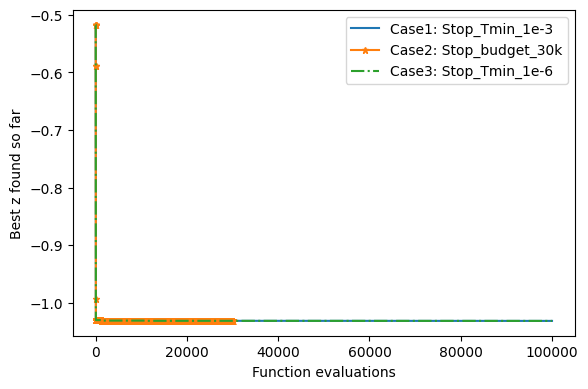

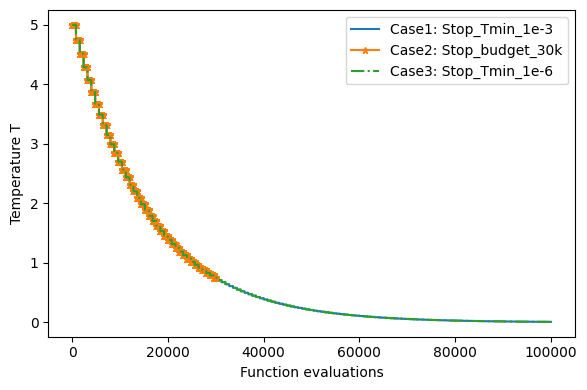

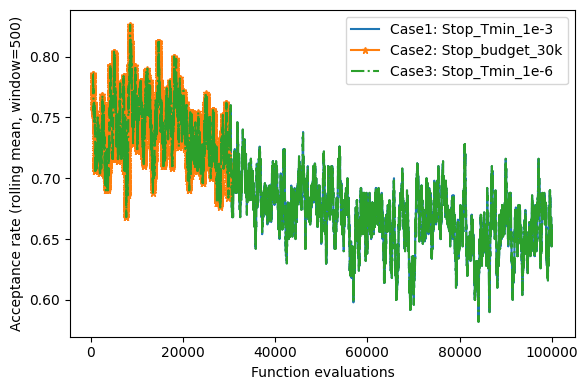

Saved PNG plots:
  step3_best_z_comparison.png
  step3_temperature_comparison.png
  step3_acceptance_rate_comparison.png

Saved CSV files:
  step3_stopping_summary.csv
  step3_trace_Case1: Stop_Tmin_1e-3.csv
  step3_trace_Case2: Stop_budget_30k.csv
  step3_trace_Case3: Stop_Tmin_1e-6.csv


In [ ]:
import matplotlib.pyplot as plt

# Define line styles and markers to differentiate the plots
linestyles = ['-', '-', '-.'] # Case1 (blue): solid, Case2 (orange): solid, Case3 (green): dashed
markers = ['', '*', '']   # Case1 (blue): no marker, Case2 (orange): star, Case3 (green): no marker

figsize=(6, 4)


# 1) Best z vs evaluations
plt.figure(figsize=figsize) # Increased figure size
for i, (name, _) in enumerate(stopping_rules):
    df = step3_traces[name]
    plt.plot(df["eval"], df["best_z"], label=name,
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],
             markersize=5, # Slightly increased marker size
             linewidth=1.5) # Added linewidth
plt.xlabel("Function evaluations")
plt.ylabel("Best z found so far")
# add a line of the code to order of the layers: case 1 => case 2 => case 3




#plt.title("Best z vs Evaluations (Different Stopping Criteria)", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step3_stopping_criteria_results/step3_best_z_comparison.png", dpi=300)
plt.show()

# 2) Temperature vs evaluations
plt.figure(figsize=figsize) # Increased figure size
for i, (name, _) in enumerate(stopping_rules):
    df = step3_traces[name]
    plt.plot(df["eval"], df["T"], label=name,
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],
             markersize=5, # Slightly increased marker size
             linewidth=1.5) # Added linewidth
plt.xlabel("Function evaluations")
plt.ylabel("Temperature T")
#plt.title("Temperature vs Evaluations (Different Stopping Criteria)", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step3_stopping_criteria_results/step3_temperature_comparison.png", dpi=300)
plt.show()

# 3) Acceptance rate comparison (rolling mean)
window = 500
plt.figure(figsize=figsize) # Increased figure size
for i, (name, _) in enumerate(stopping_rules):
    df = step3_traces[name]
    acc_rate = df["accepted"].rolling(window).mean()
    plt.plot(df["eval"], acc_rate, label=name,
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],
             markersize=5, # Slightly increased marker size
             linewidth=1.5) # Added linewidth
plt.xlabel("Function evaluations")
plt.ylabel(f"Acceptance rate (rolling mean, window={window})")
#plt.title("Acceptance Rate vs Evaluations", fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig("step3_stopping_criteria_results/step3_acceptance_rate_comparison.png", dpi=300)
plt.show()

print("Saved PNG plots:")
print("  step3_best_z_comparison.png")
print("  step3_temperature_comparison.png")
print("  step3_acceptance_rate_comparison.png")

print("\nSaved CSV files:")
print("  step3_stopping_summary.csv")
for name, _ in stopping_rules:
    print(f"  step3_trace_{name}.csv")

# 5. Step 4 — Define 5 initial starting point

In [ ]:
# 3 cooling schedules
schedules = [
    ("Case1: alpha_0.90", 0.90),
    ("Case2: alpha_0.95", 0.95),
    ("Case3:alpha_0.98", 0.98),
]

# 3 stopping criteria
stopping_rules = [
    ("Case1: Stop_Tmin_1e-3", dict(Tmin=1e-3, max_evals=100_000)),  # baseline
    ("Case2: Stop_budget_30k", dict(Tmin=0.0,  max_evals=30_000)),  # budget-limited
    ("Case3: Stop_Tmin_1e-6", dict(Tmin=1e-6, max_evals=100_000)),  # stricter Tmin
]

# 5 starting points
starts = [
    ("Case1: Start_(0,0)",    (0.0, 0.0)),
    ("Case2: Start_(-3,-2)",  (-3.0, -2.0)),
    ("Case3: Start_(-3,2)",   (-3.0, 2.0)),
    ("Case4: Start_(3,-2)",   (3.0, -2.0)),
    ("Case5: Start_(3,2)",    (3.0, 2.0)),
]

In [ ]:
import pandas as pd

COMMON_45 = dict(
    f=six_hump_camelback,
    T0=5.0,              # keep fixed for fairness (you can change if your instructor prefers)
    steps_per_T=800,
    step0=(0.6, 0.4),
)

rows = []
run_id = 0

for sched_name, alpha in schedules:
    for stop_name, stop_kwargs in stopping_rules:
        for start_name, x0 in starts:
            run_id += 1
            seed = 3000 + run_id  # unique seed per run (reproducible)

            res = simulated_annealing_minimize_trace(
                **COMMON_45,
                alpha=alpha,
                x0=x0,
                seed=seed,
                **stop_kwargs
            )

            rows.append({
                "run_id": run_id,
                "schedule": sched_name,
                "alpha": alpha,
                "stopping": stop_name,
                "Tmin": stop_kwargs["Tmin"],
                "max_evals": stop_kwargs["max_evals"],
                "start": start_name,
                "x0": x0[0],
                "y0": x0[1],
                "best_x": res["best_x"],
                "best_y": res["best_y"],
                "best_z": res["best_f"],
                "evals": res["evals"],
                "final_T": res["final_T"],
                "seed": seed,
            })

summary_45_df = pd.DataFrame(rows)
summary_45_df.to_csv("step4_combined_results/section3_45runs_summary.csv", index=False)

summary_45_df.head()

,run_id,schedule,alpha,stopping,Tmin,max_evals,start,x0,y0,best_x,best_y,best_z,evals,final_T,seed
0,1,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,"Case1: Start_(0,0)",0.0,0.0,0.089569,-0.712567,-1.031628,64801,0.000983,3001
1,2,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,"Case2: Start_(-3,-2)",-3.0,-2.0,0.089744,-0.712575,-1.031628,64801,0.000983,3002
2,3,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,"Case3: Start_(-3,2)",-3.0,2.0,-0.089644,0.712626,-1.031628,64801,0.000983,3003
3,4,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,"Case4: Start_(3,-2)",3.0,-2.0,-0.090093,0.712566,-1.031628,64801,0.000983,3004
4,5,Case1: alpha_0.90,0.9,Case1: Stop_Tmin_1e-3,0.001,100000,"Case5: Start_(3,2)",3.0,2.0,0.090072,-0.712635,-1.031628,64801,0.000983,3005


/tmp/ipython-input-798751838.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=combos, vert=True)


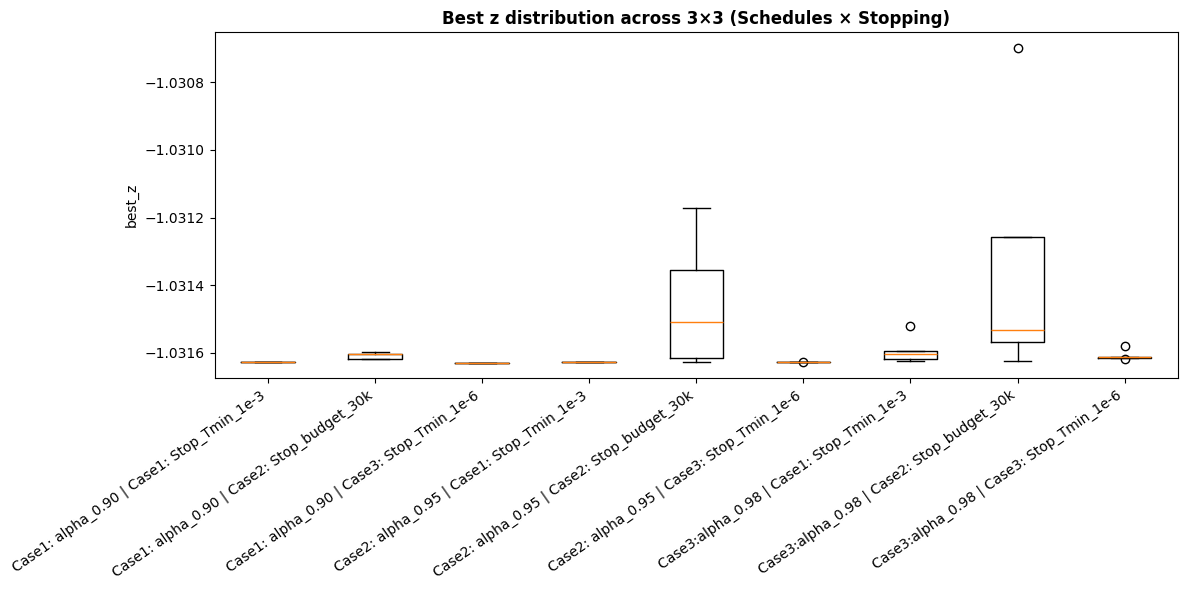

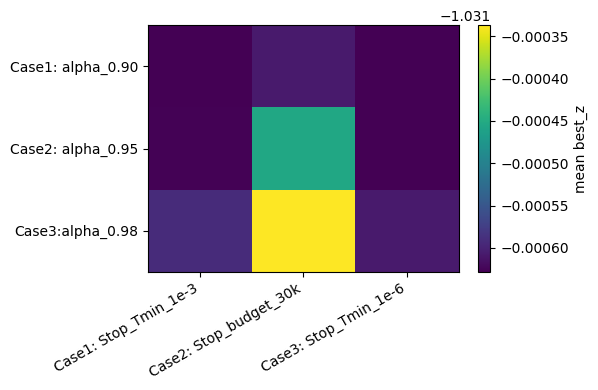

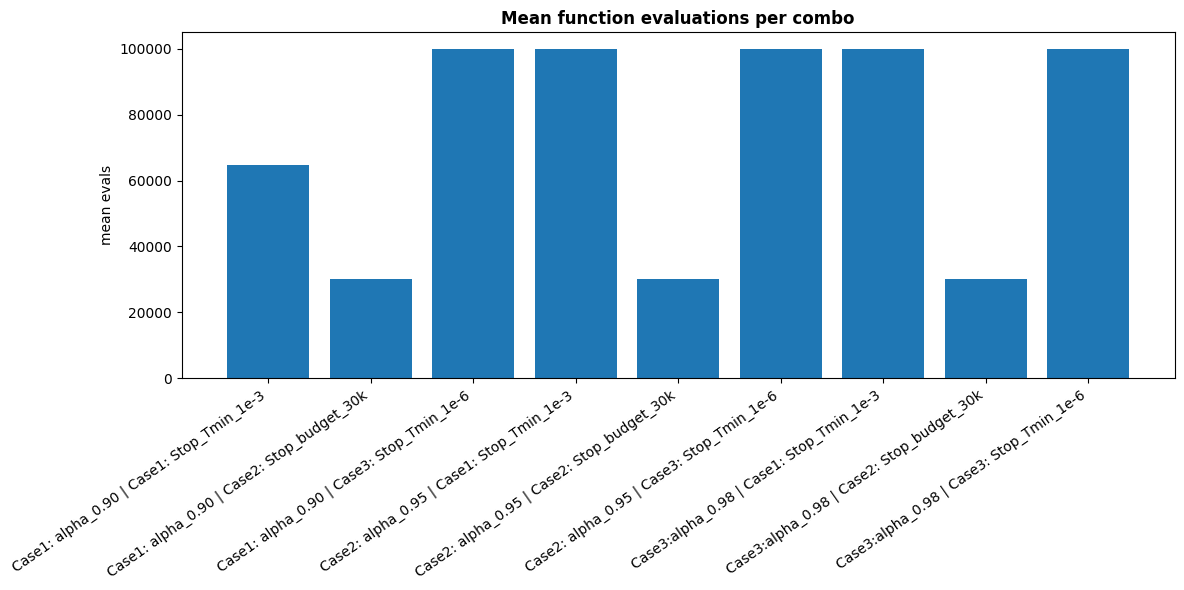

Saved:
  section3_45runs_summary.csv
  section3_boxplot_bestz.png
  section3_heatmap_mean_bestz.png
  section3_bar_mean_evals.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = summary_45_df.copy()

# Create a combo label (schedule + stopping)
df["combo"] = df["schedule"] + " | " + df["stopping"]

# 1) Boxplot: best_z distribution per combo
combos = sorted(df["combo"].unique())
data = [df.loc[df["combo"] == c, "best_z"].values for c in combos]

plt.figure(figsize=(12, 6))
plt.boxplot(data, labels=combos, vert=True)
plt.xticks(rotation=35, ha="right")
plt.ylabel("best_z")
plt.title("Best z distribution across 3×3 (Schedules × Stopping)", fontweight='bold')
plt.tight_layout()
plt.savefig("step4_combined_results/section3_boxplot_bestz.png", dpi=300)
plt.show()

# 2) Heatmap: mean best_z for each schedule × stopping
pivot_mean = df.pivot_table(index="schedule", columns="stopping", values="best_z", aggfunc="mean")
plt.figure(figsize=(6, 4))
plt.imshow(pivot_mean.values, aspect="auto")
plt.xticks(range(pivot_mean.shape[1]), pivot_mean.columns, rotation=30, ha="right")
plt.yticks(range(pivot_mean.shape[0]), pivot_mean.index)
plt.colorbar(label="mean best_z")
#plt.title("Mean best_z heatmap (schedule × stopping)", fontweight='bold')
plt.tight_layout()
plt.savefig("step4_combined_results/section3_heatmap_mean_bestz.png", dpi=300)
plt.show()

# 3) Bar plot: mean evals per combo
mean_evals = df.groupby("combo")["evals"].mean().reindex(combos)

plt.figure(figsize=(12, 6))
plt.bar(mean_evals.index, mean_evals.values)
plt.xticks(rotation=35, ha="right")
plt.ylabel("mean evals")
plt.title("Mean function evaluations per combo", fontweight='bold')
plt.tight_layout()
plt.savefig("step4_combined_results/section3_bar_mean_evals.png", dpi=300)
plt.show()

print("Saved:")
print("  section3_45runs_summary.csv")
print("  section3_boxplot_bestz.png")
print("  section3_heatmap_mean_bestz.png")
print("  section3_bar_mean_evals.png")